# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Word2Vec" data-toc-modified-id="Word2Vec-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Word2Vec</a></div><div class="lev2 toc-item"><a href="#Preâmbulo" data-toc-modified-id="Preâmbulo-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Preâmbulo</a></div><div class="lev2 toc-item"><a href="#Preparando-o-dataset" data-toc-modified-id="Preparando-o-dataset-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Preparando o dataset</a></div><div class="lev3 toc-item"><a href="#Buscando-o-texto-dos-livros-e-definindo-os-rótulos" data-toc-modified-id="Buscando-o-texto-dos-livros-e-definindo-os-rótulos-121"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Buscando o texto dos livros e definindo os rótulos</a></div><div class="lev3 toc-item"><a href="#Representando-as-palavras-através-de-índices-inteiros" data-toc-modified-id="Representando-as-palavras-através-de-índices-inteiros-122"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Representando as palavras através de índices inteiros</a></div><div class="lev3 toc-item"><a href="#Palavras-características-de-cada-livro" data-toc-modified-id="Palavras-características-de-cada-livro-123"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Palavras características de cada livro</a></div><div class="lev2 toc-item"><a href="#Word2Vec" data-toc-modified-id="Word2Vec-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Word2Vec</a></div>

# Word2Vec

## Preâmbulo

In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display
from __future__ import print_function

import os
import re
import sys
import glob
import numpy as np
import numpy.random as nr

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.optimizers import (SGD, 
                              RMSprop, 
                              Adam, 
                              Adadelta, 
                              Adagrad)

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

os.makedirs('../../models',exist_ok=True)
np.set_printoptions(precision=3, linewidth=120)

Using TensorFlow backend.


In [2]:
import keras.backend as K

# K.set_image_data_format('channels_first')
K.set_floatx('float32')

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_first
Available GPUS: []


## Preparando o dataset

### Buscando o texto dos livros e definindo os rótulos

In [3]:
data_dir = '../../datasets/livros/'

autores = [
    'Fernando_Sabino', 
    'Jorge_Amado',
    'Machado_de_Assis',
]

book_text = []
book_author = []
book_title = []
for aut in autores:
    for fn in glob.glob(data_dir + aut + '*.txt'):
        author, book = os.path.basename(fn).split('__')
        txt = open(fn).read().replace('\x97', '')
        book_text.append(txt)
        book_author.append(author)
        book_title.append(book[:-4])
        print('{:7d}  {:18s} {}'.format(len(txt), author, book[:-4]))

author_list = list(set(book_author))
n_labels = len(author_list)
n_books = len(book_title)
book_label = [author_list.index(a) for a in book_author]
print('\nLabels:')
for i, autor in enumerate(author_list):
    print('    {:2d}: {}'.format(i, autor))

  87788  Fernando_Sabino    O_Bom_Ladrão
 511681  Fernando_Sabino    O_Encontro_Marcado
 328288  Fernando_Sabino    O_Grande_Mentecapto
 180313  Fernando_Sabino    O_Menino_no_Espelho
 427711  Jorge_Amado        Capitães_de_Areia
1030735  Jorge_Amado        Dona_flor_seus_dois_maridos
 828417  Jorge_Amado        Gabriela
1001226  Jorge_Amado        Tereza_Batista_Cansada_de_Guerra
 372459  Machado_de_Assis   Dom_Casmurro
 411043  Machado_de_Assis   Esaú_e_Jacó
 352965  Machado_de_Assis   Memórias_Póstumas_de_Brás_Cubas
 443778  Machado_de_Assis   Quincas_Borba

Labels:
     0: Fernando_Sabino
     1: Jorge_Amado
     2: Machado_de_Assis


### Representando as palavras através de índices inteiros

In [4]:
MAX_NB_WORDS = 50000

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(book_text)
sequences = tokenizer.texts_to_sequences(book_text)

w2i = tokenizer.word_index
i2w = dict([(v, k) for k, v in w2i.items()])

i2w_vec = np.array([i2w[i+1] for i in range(len(i2w))])

print('Found %s unique tokens.' % len(w2i))

Found 51557 unique tokens.


In [5]:
word_sequences = []
for i, seq in enumerate(sequences):
    k = nr.randint(len(seq) - 100)
    word_sequences.append([i2w[x] for x in seq])
    print('{}: {} -- {} palavras'.format(book_author[i], book_title[i], len(seq)).replace('_', ' '))
    # print(' '.join([i2w[x] for x in seq[k:k+100]]), end='\n\n')


Fernando Sabino: O Bom Ladrão -- 15139 palavras
Fernando Sabino: O Encontro Marcado -- 87226 palavras
Fernando Sabino: O Grande Mentecapto -- 56091 palavras
Fernando Sabino: O Menino no Espelho -- 31938 palavras
Jorge Amado: Capitães de Areia -- 78337 palavras
Jorge Amado: Dona flor seus dois maridos -- 175457 palavras
Jorge Amado: Gabriela -- 140073 palavras
Jorge Amado: Tereza Batista Cansada de Guerra -- 174570 palavras
Machado de Assis: Dom Casmurro -- 66969 palavras
Machado de Assis: Esaú e Jacó -- 72640 palavras
Machado de Assis: Memórias Póstumas de Brás Cubas -- 61492 palavras
Machado de Assis: Quincas Borba -- 76423 palavras


### Palavras características de cada livro

In [6]:
tfidf = tokenizer.sequences_to_matrix(sequences, mode='tfidf')
ww = np.argsort(tfidf, axis=1)[:, -8:]
print(i2w_vec[ww-1])

[['que' 'de' 'garcia' 'brígida' 'norberto' 'abotoaduras' '–' 'isabel']
 ['eduardo' 'marciano' '“' 'vítor' 'gerlane' 'mauro' 'térsio' '—']
 ['tibério' 'dionísio' 'barbeca' 'ladisbão' '—' 'mentecapto' 'geraldo' 'viramundo']
 ['pastoff' 'alzira' 'odnanref' 'birica' 'anairam' 'hindemburgo' 'gerson' '—']
 ['ester' 'dalva' 'barandão' 'almiro' 'dora' '–' 'pirulito' 'trapiche']
 ['marilda' 'dinorá' 'teodoro' 'pelancchi' 'gisa' 'mirandão' 'rozilda' 'vadinho']
 ['arminda' 'malvina' 'mundinho' 'amâncio' 'fulgêncio' 'tonico' 'gabriela' 'nacib']
 ['libório' 'vavá' 'almério' 'januário' '—' 'dóris' 'justiniano' 'tereza']
 ['protonotário' 'bentinho' 'cabral' 'sancha' 'pádua' 'justina' 'capitu' 'escobar']
 ['cabocla' 'perpétua' 'excia' 'custódio' 'aires' 'natividade' 'cláudia' 'flora']
 ['loló' 'eusébia' 'cubas' 'quincas' 'sabina' 'cotrim' 'marcela' 'virgília']
 ['cristiano' 'fernanda' 'quincas' 'tonica' 'camacho' 'benedita' 'sofia' 'rubião']]


## Word2Vec

In [7]:
import logging
from gensim.models import Word2Vec
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

model_fn = '../../models/wv_pt_br'
model = Word2Vec(word_sequences, min_count=3, size=100, window=5, max_vocab_size=None)
model.save(model_fn)

word_vectors = model.wv
del model

2017-06-09 12:03:29,788 : INFO : collecting all words and their counts
2017-06-09 12:03:29,790 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-06-09 12:03:29,987 : INFO : collected 49999 word types from a corpus of 1036355 raw words and 12 sentences
2017-06-09 12:03:29,988 : INFO : Loading a fresh vocabulary
2017-06-09 12:03:30,188 : INFO : min_count=3 retains 21357 unique words (42% of original 49999, drops 28642)
2017-06-09 12:03:30,190 : INFO : min_count=3 leaves 1000153 word corpus (96% of original 1036355, drops 36202)
2017-06-09 12:03:30,309 : INFO : deleting the raw counts dictionary of 49999 items
2017-06-09 12:03:30,312 : INFO : sample=0.001 downsamples 39 most-common words
2017-06-09 12:03:30,314 : INFO : downsampling leaves estimated 763603 word corpus (76.3% of prior 1000153)
2017-06-09 12:03:30,315 : INFO : estimated required memory for 21357 words and 100 dimensions: 27764100 bytes
2017-06-09 12:03:30,406 : INFO : resetting layer weights
20

In [8]:
data = word_vectors.syn0
words = word_vectors.index2word

data.shape, data.min(), data.max()

((21357, 100), -3.0406098, 2.8944137)

In [9]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

tsne = TSNE(perplexity=50, n_components=2, init='pca', n_iter=1000, verbose=2)
low_dim = tsne.fit_transform(data)

# pca = PCA(n_components=2)
# low_dim = pca.fit_transform(data)
low_dim.shape

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 21357
[t-SNE] Computed conditional probabilities for sample 2000 / 21357
[t-SNE] Computed conditional probabilities for sample 3000 / 21357
[t-SNE] Computed conditional probabilities for sample 4000 / 21357
[t-SNE] Computed conditional probabilities for sample 5000 / 21357
[t-SNE] Computed conditional probabilities for sample 6000 / 21357
[t-SNE] Computed conditional probabilities for sample 7000 / 21357
[t-SNE] Computed conditional probabilities for sample 8000 / 21357
[t-SNE] Computed conditional probabilities for sample 9000 / 21357
[t-SNE] Computed conditional probabilities for sample 10000 / 21357
[t-SNE] Computed conditional probabilities for sample 11000 / 21357
[t-SNE] Computed conditional probabilities for sample 12000 / 21357
[t-SNE] Computed conditional probabilities for sample 13000 / 21357
[t-SNE] Computed conditional probabilities

(21357, 2)

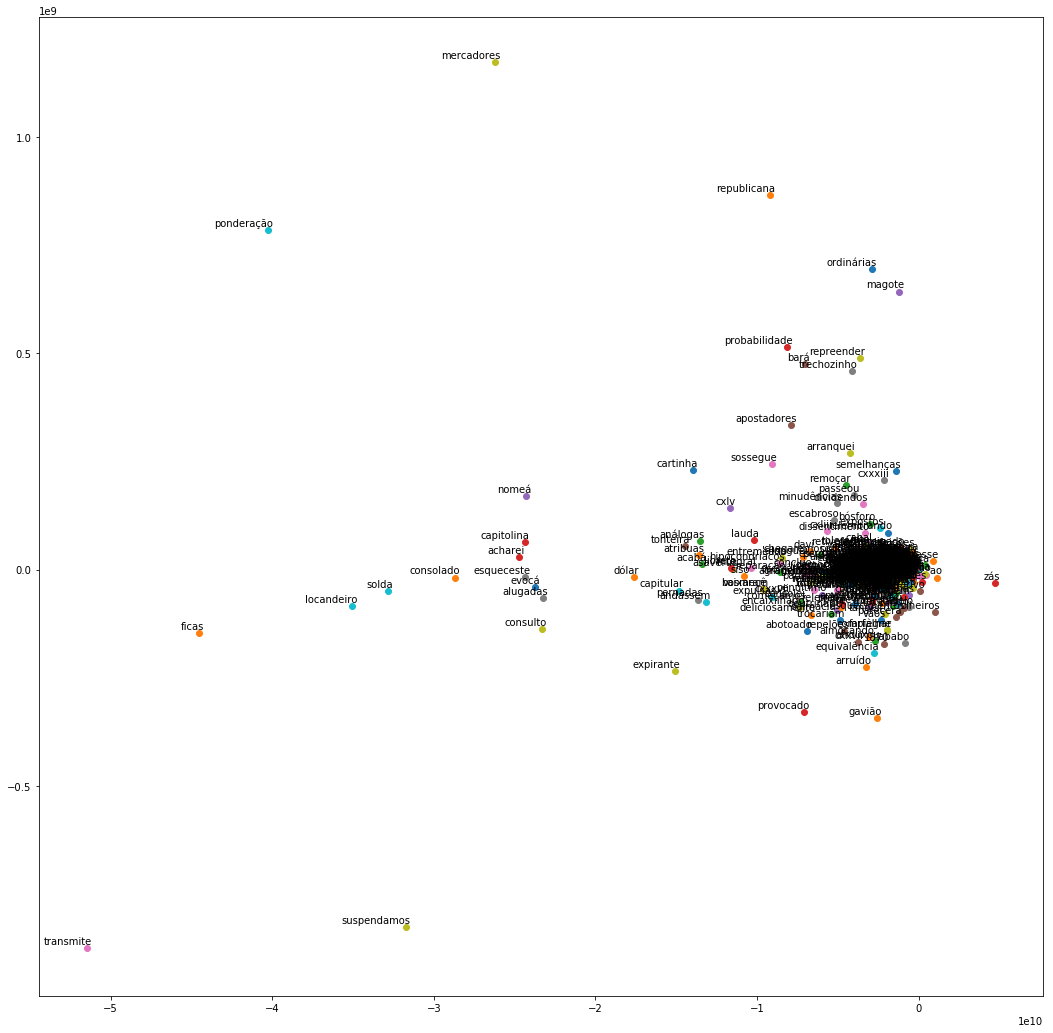

In [14]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plot.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plot.scatter(x, y)
        plot.annotate(label,
                      xy=(x, y),
                      xytext=(5, 2),
                      textcoords='offset points',
                      ha='right',
                      va='bottom')
    plot.savefig(filename)

low_dim = low_dim[::-1]
words = words[::-1]
    
plot_with_labels(low_dim[:500,:], words[:500])
